Make that we are running the correct version of TensorFlow first

In [2]:
import tensorflow as tf
tf.__version__

/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/share/virtualenvs/line-reader-3vKrZmrE/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtyp

'2.0.0-beta1'

In [3]:
import sys

assert sys.version_info >= (3, 6) # Python ≥3.6 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

# Build a lines segmentation model based on unet architecture 

Here is [the paper](https://arxiv.org/pdf/1505.04597.pdf)

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')

from pathlib import Path
Path.ls = lambda x: list(x.iterdir())  # Source: https://github.com/fastai/fastai/blob/master/fastai/core.py#L236

from tqdm import tqdm

from PIL import Image

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [5]:
from recognizer.datasets import Dataset
from recognizer.networks import unet
from recognizer.networks import NetworkInput

In [6]:
lines_detector_path = Dataset.processed_data_path()/"lines_detector"
lines_detector_images_path = lines_detector_path/"images"
lines_detector_masks_path = lines_detector_path/"masks"

Hyperparameters

In [7]:
batch_size = 4
epochs = 5

In [8]:
model_save_path = Path("../recognizer/weights/lines_detector.h5")

## Load dataset

In [9]:
x = []
y = []

sorted_image_names = sorted(lines_detector_images_path.glob("*.jpg"))
sorted_mask_names = sorted(lines_detector_masks_path.glob("*.png"))
for image_file_name, mask_file_name in tqdm(zip(sorted_image_names, sorted_mask_names)):
    image = img_to_array(Image.open(image_file_name)) / 255
    mask = img_to_array(Image.open(mask_file_name), dtype=np.uint8) // 127
    
    x.append(image)
    y.append(mask)

x = np.array(x)
y = np.array(y)

# len(x), x[0].shape
x.shape

1539it [00:10, 153.10it/s]


(1539, 256, 256, 1)

In [10]:
x[0].dtype, y[0].dtype

(dtype('float32'), dtype('uint8'))

## Augment the data

## Build the model

In [11]:
np.unique(y)

array([0, 1, 2], dtype=uint8)

In [12]:
input_shape = x[0].shape
number_of_classes = 3

y = to_categorical(y, number_of_classes)
y.shape

(1539, 256, 256, 3)

In [29]:
model = unet(NetworkInput(input_shape=input_shape, number_of_classes=number_of_classes))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

## Train the model

Check progress in TensorBoard by running tensorboard --logdir=logs/lines_detector_model in terminal

In [30]:
# Try removing the old logs first
!rm -r ../logs/lines_detector_model

callbacks = [
    keras.callbacks.TensorBoard(log_dir='../logs/lines_detector_model')
]

In [31]:
model.compile(optimizer=Adam(lr=1e-2),  # RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    x,
    y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=.2,
    shuffle=True
)
history.history.keys()

Train on 1231 samples, validate on 308 samples
Epoch 1/5
1188/1231 [===========================>..] - ETA: 1s - loss: 1.5106 - accuracy: 0.0869

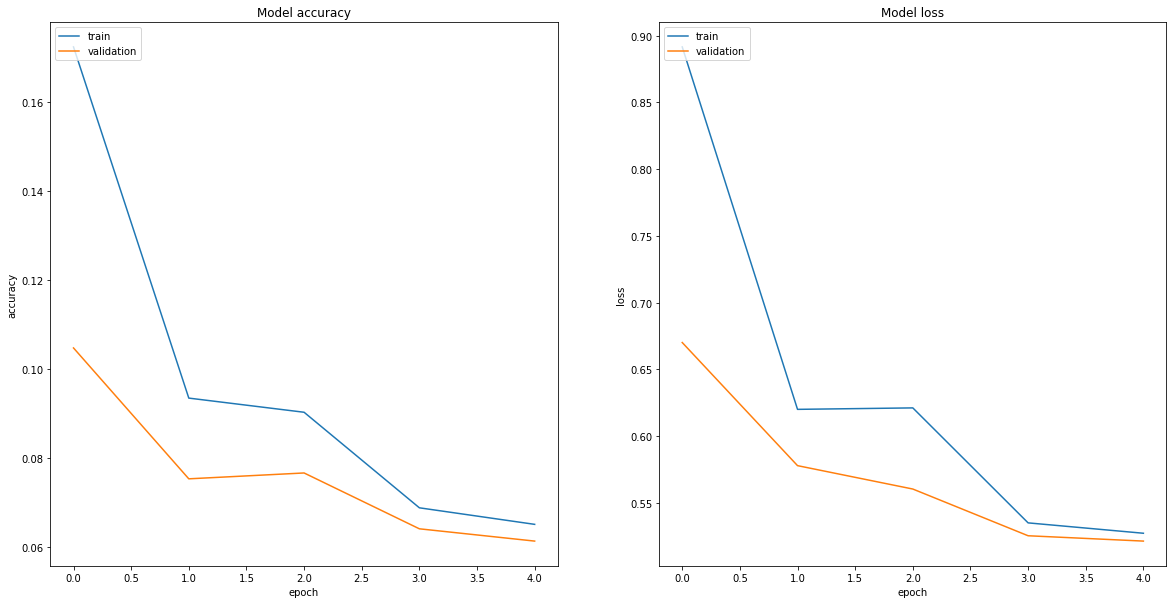

In [33]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

# Save the model

In [36]:
model.save(model_save_path)

## Restore the model

In [13]:
model = keras.models.load_model(model_save_path)

model.trainable = False
model.compile(optimizer=Adam(lr=1e-2),  # RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.trainable_variables

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[]

## Predict on one image

In [37]:
image_array = x[0]
test_batch = image_array.reshape((1,) + image_array.shape)

preds = model.predict(test_batch)
preds.shape

(1, 256, 256, 3)

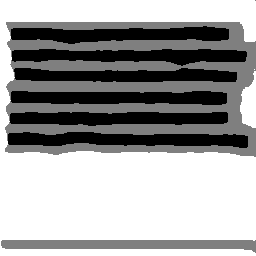

In [38]:
# Merge the 3 channel classes into one for color
pred_image_array = np.expand_dims(np.argmax(preds[0], axis=2), axis=-1)
array_to_img(pred_image_array)

In [39]:
np.min(preds[0]), np.max(preds[0])

(-22873444000000.0, 9202413000000.0)

In [40]:
np.min(pred_image_array), np.max(pred_image_array)

(0, 2)

In [41]:
np.argmax(preds[0], axis=1).shape

(256, 3)

In [42]:
np.argmax(preds[0], axis=2).shape

(256, 256)

In [43]:
np.expand_dims(np.argmax(preds[0], axis=2), axis=-1).shape

(256, 256, 1)

In [44]:
pred_image_array.shape

(256, 256, 1)

Check predication array

In [45]:
for row in preds[0]:
    if np.max(row) > 0:
        print(row)

[[-3.22297319e+12  3.17837046e+10  1.93097892e+11]
 [-5.77670637e+12  9.13978163e+10  3.43722623e+11]
 [-7.85201286e+12  1.34910575e+11  4.56206942e+11]
 [-9.17722418e+12  1.62617311e+11  5.28865133e+11]
 [-1.04510930e+13  1.93029685e+11  5.92144892e+11]
 [-1.11529668e+13  2.11115016e+11  6.26146214e+11]
 [-1.17789153e+13  2.29231411e+11  6.50398269e+11]
 [-1.21245721e+13  2.39897068e+11  6.62429762e+11]
 [-1.24438603e+13  2.50979582e+11  6.69119545e+11]
 [-1.26176010e+13  2.57217561e+11  6.72310559e+11]
 [-1.27310108e+13  2.62541918e+11  6.71139955e+11]
 [-1.27661171e+13  2.64534983e+11  6.70024335e+11]
 [-1.27607148e+13  2.65781707e+11  6.67089175e+11]
 [-1.27294557e+13  2.65463087e+11  6.65017188e+11]
 [-1.26718501e+13  2.64479638e+11  6.62155297e+11]
 [-1.26225471e+13  2.63165231e+11  6.60406272e+11]
 [-1.25713714e+13  2.61763334e+11  6.58706661e+11]
 [-1.25429225e+13  2.60897849e+11  6.57715364e+11]
 [-1.25322521e+13  2.60480205e+11  6.57031168e+11]
 [-1.25411839e+13  2.60760044e+

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
np.argmax(preds[0], axis=2).shape

(256, 256)

In [24]:
for row in np.argmax(preds[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")

>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY

Check target array

In [25]:
for row in y[0]:
    if np.max(row) > 0:
        print(row)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1.

In [26]:
np.argmax(y[0], axis=2).shape

(256, 256)

In [27]:
for row in np.argmax(y[0], axis=2):
    if np.max(row) > 0:
        print(row)
    else:
        print(">> EMPTY ROW <<")

>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
>> EMPTY ROW <<
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1